### Offsets (zyx) and shapes

ndc10gfp_g7_l1_ts_002_ctf: (322, 782, 330), (350, 350)

ndc10gfp_g8_l3_ts_002_ctf: (336, 821, 508), (680, 680)

rotacell_grid1_TS10_ctf: (297, 217, 281) (, 445)0)50, 

SMH825_ctf: (494, 333, 828), (450, 450)

In [1]:
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from copy import copy


def load(path):
    return mrcfile.mmap(path, mode="r").data


def crop(data, x0, shape):
    data = np.flip(np.asarray(data), axis=1)
    return np.asarray(data[x0[0], x0[1] : x0[1] + shape[0], x0[2] : x0[2] + shape[1]])


def save(save_path, data):
    with mrcfile.new(save_path, overwrite=True) as mrc:
        mrc.set_data(data)


def sigma_bounds(image, sigma=2):
    mean = np.mean(image)
    std = np.std(image)

    lower_value = mean - sigma * std
    upper_value = mean + sigma * std

    return lower_value, upper_value


def auto_contrast(image, sigma=2):
    lower_value, upper_value = sigma_bounds(image, sigma=sigma)

    return np.clip(image, lower_value, upper_value)


def normalize(img):
    return (img - img.min()) / (img.max() - img.min())


def combine_diagonal(img1, img2, angle=1, offset=0, invert=False):
    img1 = normalize(img1)
    img2 = normalize(img2)

    x = np.linspace(-1, 1, img1.shape[0])
    X, Y = np.meshgrid(x, x)

    mask = Y > angle * X + offset

    return img1 * mask + img2 * (1 - mask)

In [2]:
raw_1_path = "/nfs/datasync4/inacio/data/raw_data/cryo/novareconstructions/ndc10gfp_g7_l1_ts_002_ctf_3xBin.rec"
raw_2_path = "/nfs/datasync4/inacio/data/raw_data/cryo/novareconstructions/ndc10gfp_g8_l3_ts_002_ctf_3xBin.rec"
raw_3_path = "/nfs/datasync4/inacio/data/raw_data/cryo/novareconstructions/rotacell_grid1_TS10_ctf_3xBin.rec"
raw_4_path = (
    "/nfs/datasync4/inacio/data/raw_data/cryo/novareconstructions/SMH825_ctf_3xBin.rec"
)
cs_1_path = "/nfs/datasync4/inacio/data/denoising/cryosamba/ndc10gfp_g7_l1_ts_002_ctf_3xBin/inference/result.rec"
cs_2_path = "/nfs/datasync4/inacio/data/denoising/cryosamba/ndc10gfp_g8_l3_ts_002_ctf_3xBin/inference/result.rec"
cs_3_path = "/nfs/datasync4/inacio/data/denoising/cryosamba/rotacell_grid1_TS10_ctf_3xBin/inference/result.rec"
cs_4_path = "/nfs/datasync4/inacio/data/denoising/cryosamba/SMH825_ctf_3xBin/inference/result.rec"

x0_list = [[322, 782, 330], [336, 821, 508], [297, 217, 281], [494, 333, 828]]
shape_list = [[350, 350], [680, 680], [450, 450], [450, 450]]
sigma = 1.1

raw = [load(raw_1_path), load(raw_2_path), load(raw_3_path), load(raw_4_path)]
cs = [load(cs_1_path), load(cs_2_path), load(cs_3_path), load(cs_4_path)]

raw = [crop(data, x0, shape) for data, x0, shape in zip(raw, x0_list, shape_list)]
cs = [crop(data, x0, shape) for data, x0, shape in zip(cs, x0_list, shape_list)]

raw[-1] = np.rot90(raw[-1], 1)
cs[-1] = np.rot90(cs[-1], 1)
# raw[-1] = np.flip(raw[-1],(0,1))
# cs[-1] = np.flip(cs[-1],(0,1))

raw[-2] = np.flip(raw[-2], (0, 1))
cs[-2] = np.flip(cs[-2], (0, 1))

raw = [auto_contrast(image, sigma=sigma) for image in raw]
cs = [auto_contrast(image, sigma=sigma) for image in cs]

angle = [-1, -1, -1, -1]
offset = [0, 0, 0, 0]

combined = [
    combine_diagonal(cs[i], raw[i], angle=angle[i], offset=offset[i]) for i in range(4)
]

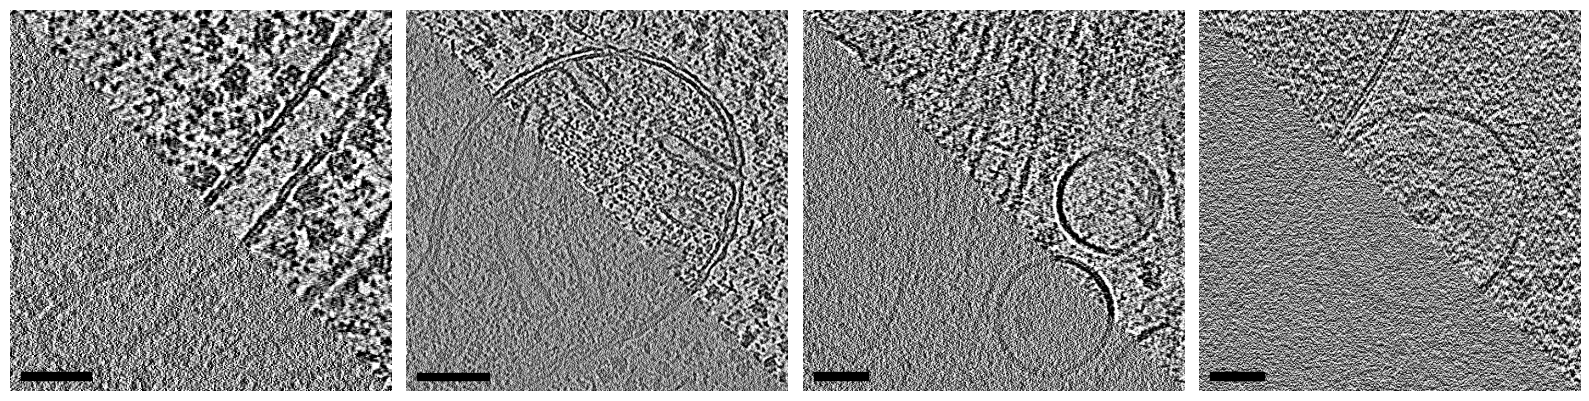

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

voxel_size = 2.62 * 3
nm_size = [500, 1000, 500, 500]

for i in range(4):
    ax = axs[i]
    ax.imshow(combined[i], cmap="grey")
    ax.invert_yaxis()
    ax.set_axis_off()

    base_size = combined[i].shape[0] / 350
    scale_length, scale_width, scale_x0 = (
        nm_size[i] / voxel_size,
        base_size * 20 / 3,
        (base_size * 30 / 3, base_size * 30 / 3),
    )
    scalebar = patches.Rectangle(
        scale_x0,
        scale_length,
        scale_width,
        linewidth=1,
        edgecolor="black",
        facecolor="black",
    )
    ax.add_patch(scalebar)


plt.tight_layout()
# plt.savefig('fig02.svg', format='svg')
plt.show()

In [6]:
combined[0].shape

(350, 350)